# Melanoma detector
    SafeSpot

## Library

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
import os
import glob
import pickle
import pandas as pd
import imageio
from sklearn.metrics import roc_auc_score, roc_curve, auc
import seaborn as sns
import shutil
from numpy import random as rd

import tensorflow as tf
from keras.models import load_model
from keras import layers 
from keras.layers import Concatenate, Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D 
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D 
from keras.models import Model, Sequential 
from keras.preprocessing import image 
from keras.utils import layer_utils 
from keras.utils.data_utils import get_file 
from keras.applications.imagenet_utils import preprocess_input 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

%matplotlib inline

## Data exploration

In [2]:
dados = pd.read_csv('C:/Users/Felip/Documents/ISBI2016_ISIC_Part3_Training_GroundTruth.csv', header = None, names = ['ID', 'Mel'])
dados.head()

,ID,Mel
0,ISIC_0000000,benign
1,ISIC_0000001,benign
2,ISIC_0000002,malignant
3,ISIC_0000004,malignant
4,ISIC_0000006,benign


In [3]:
dados.info

<bound method DataFrame.info of                ID        Mel
0    ISIC_0000000     benign
1    ISIC_0000001     benign
2    ISIC_0000002  malignant
3    ISIC_0000004  malignant
4    ISIC_0000006     benign
..            ...        ...
895  ISIC_0011393     benign
896  ISIC_0011397     benign
897  ISIC_0011398     benign
898  ISIC_0011400     benign
899  ISIC_0011402     benign

[900 rows x 2 columns]>

In [4]:
dados['Mel'].value_counts()

benign       727
malignant    173
Name: Mel, dtype: int64

<AxesSubplot:xlabel='Mel', ylabel='count'>

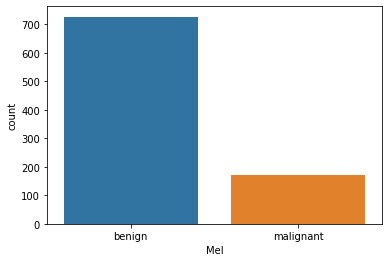

In [5]:
sns.countplot(data = dados, x ='Mel')

In [7]:
os.chdir('C:/Users/Felip/Documents/ISBI2016_ISIC_Part3_Training_Data/')
files = glob.glob('*.jpg')

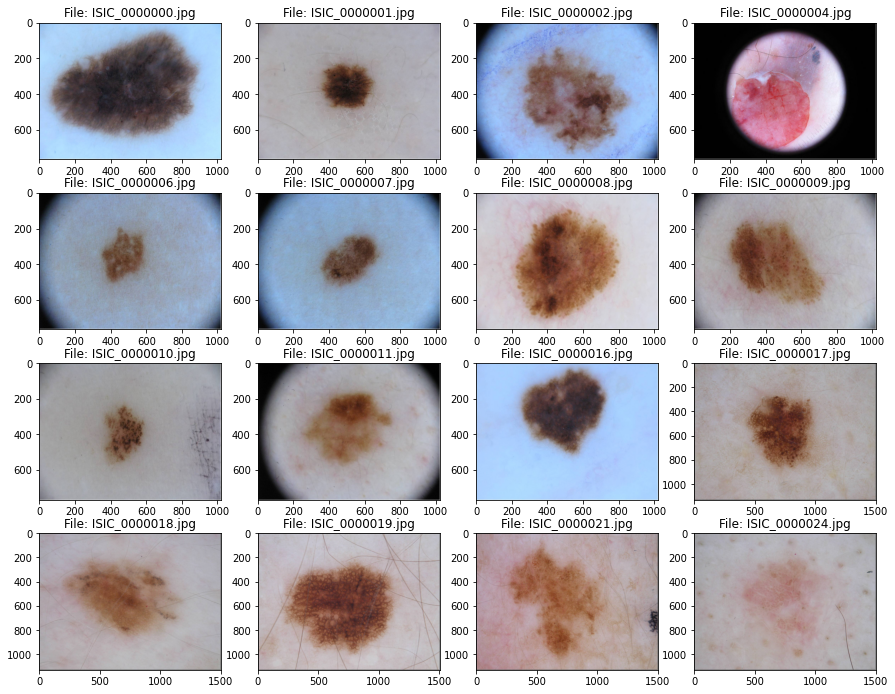

In [8]:
fig = plt.figure(figsize = (15,12))
for j in range(0,16):
    dataset = Image.open(files[j])
    fig.add_subplot(4,4,j + 1).imshow(dataset)
    plt.title("File: " + files[j])

In [9]:
def Melanoma(FILE_NAME):
    imgloc = dados[dados['ID'] == FILE_NAME[:12]]
    return imgloc.iloc[0,1]

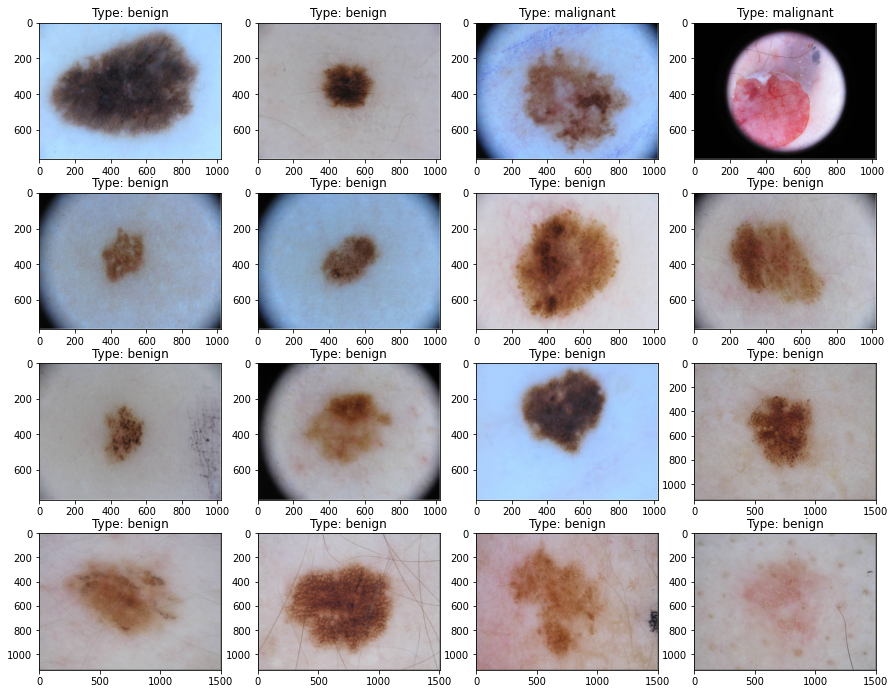

In [10]:
fig = plt.figure(figsize=(15,12))
for j in range(0,16):
    dataset = Image.open(files[j])
    fig.add_subplot(4,4,j+1).imshow(dataset)
    doenca = Melanoma(files[j])    
    plt.title("Type: " + doenca)

## Resize and Augmentation

In [11]:
def separe_files(FOLDER_NAME, OLD_ADRESS, KEY):
    os.makedirs(FOLDER_NAME)
    
    newAdress = OLD_ADRESS + FOLDER_NAME + '/'
    
    move = dados[dados['Mel'] == KEY]
    
    for imageid in move['ID']:
        shutil.move(OLD_ADRESS + imageid + '.jpg', newAdress + imageid + '.jpg')

In [12]:
adress = 'C:/Users/Felip/Documents/ISBI2016_ISIC_Part3_Training_Data/'
separe_files('benignori', adress, 'benign')
separe_files('malignantori', adress, 'malignant')

In [13]:
os.makedirs('C:/Users/Felip/Documents/ISBI2016_ISIC_Part3_Training_Data/train/benign/')
os.makedirs('C:/Users/Felip/Documents/ISBI2016_ISIC_Part3_Training_Data/train/malignant/')

In [14]:
def augmentation(PATH, OUTPUT_PATH, PREFIX, IMG_NUMBER):
    os.chdir(PATH)
    files = glob.glob("*.jpg")
    
    for img in files:
        image = load_img(img)
        image = image.resize((250,250))
        
        image = img_to_array(image)
        image = np.expand_dims(image, axis = 0)
        
        imgAug = ImageDataGenerator(rotation_range = 45, width_shift_range = 0.1,
                            height_shift_range = 0.1, zoom_range = 0.25,
                            fill_mode = 'nearest', horizontal_flip = True, vertical_flip = True)
    
        imgGen = imgAug.flow(image, save_to_dir = OUTPUT_PATH,
                     save_format = 'jpg', save_prefix = PREFIX + img)
        
        counter = 0
        for (i, newImage) in enumerate(imgGen):
            counter += 1
 
            if counter == IMG_NUMBER:
                break

In [18]:
path = 'C:/Users/Felip/Documents/ISBI2016_ISIC_Part3_Training_Data/benignori/'
output = 'C:/Users/Felip/Documents/ISBI2016_ISIC_Part3_Training_Data/train/benign/'
prefix = 'AUG'

augmentation(path, output, prefix, 7)

In [20]:
path = 'C:/Users/Felip/Documents/ISBI2016_ISIC_Part3_Training_Data/malignantori/'
output = 'C:/Users/Felip/Documents//ISBI2016_ISIC_Part3_Training_Data/train/malignant/'

augmentation(path, output, prefix, 15)

## Remove files

In [25]:
path = 'C:/Users/Felip/Documents/ISBI2016_ISIC_Part3_Training_Data/train/benign/'
os.chdir(path)
files = glob.glob("*.jpg")

imagens = rd.choice(range(len(files)), size = len(files) - 2592, replace = False)

idx = 0
for k in imagens:
    remove = os.path.join(path, files[k])
    os.remove(remove)
    idx += 1
    if (idx % 100 == 0):
        print(idx)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400


## Create dataset

In [27]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/Users/Felip/Documents/ISBI2016_ISIC_Part3_Training_Data/train/',
    validation_split = 0.2,
    subset = "training",
    label_mode = 'binary',
    seed = 1995,
    image_size = (250, 250),
    batch_size = 32
)

Found 5184 files belonging to 2 classes.
Using 4148 files for training.


In [28]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'C:/Users/Felip/Documents/ISBI2016_ISIC_Part3_Training_Data/train/',
    validation_split = 0.2,
    subset = "validation",
    label_mode = 'binary',
    seed = 123,
    image_size = (250, 250),
    batch_size = 32
)

Found 5184 files belonging to 2 classes.
Using 1036 files for validation.


In [29]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malignant']


In [30]:
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = (250, 250, 3)),
    layers.Conv2D(32, 3, activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Conv2D(32, 3, activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(2, activation = 'softmax')
])

model.compile(
    optimizer = 'Adam',
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 250, 250, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 32)        0

In [31]:
history = model.fit(train_ds, validation_data = val_ds, epochs = 20)

Epoch 1/20
130/130 [==============================] - 155s 1s/step - loss: 0.7012 - accuracy: 0.5043 - val_loss: 0.6870 - val_accuracy: 0.5521
Epoch 2/20
130/130 [==============================] - 134s 1s/step - loss: 0.6934 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.4923
Epoch 3/20
130/130 [==============================] - 135s 1s/step - loss: 0.6923 - accuracy: 0.5080 - val_loss: 0.6761 - val_accuracy: 0.5695
Epoch 4/20
130/130 [==============================] - 134s 1s/step - loss: 0.6872 - accuracy: 0.5487 - val_loss: 0.6762 - val_accuracy: 0.5347
Epoch 5/20
130/130 [==============================] - 133s 1s/step - loss: 0.6850 - accuracy: 0.5572 - val_loss: 0.6753 - val_accuracy: 0.5290
Epoch 6/20
130/130 [==============================] - 134s 1s/step - loss: 0.6819 - accuracy: 0.5366 - val_loss: 0.6723 - val_accuracy: 0.5541
Epoch 7/20
130/130 [==============================] - 135s 1s/step - loss: 0.6682 - accuracy: 0.5794 - val_loss: 0.6575 - val_accuracy: 0.5782

In [32]:
model.save('C:/Users/Felip/Documents/model_1.h5')

In [34]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
path0 = 'C:/Users/Felip/Documents/model1.tflite'
with open(path0, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\felip\AppData\Local\Temp\tmp5_396cdc\assets


INFO:tensorflow:Assets written to: C:\Users\felip\AppData\Local\Temp\tmp5_396cdc\assets


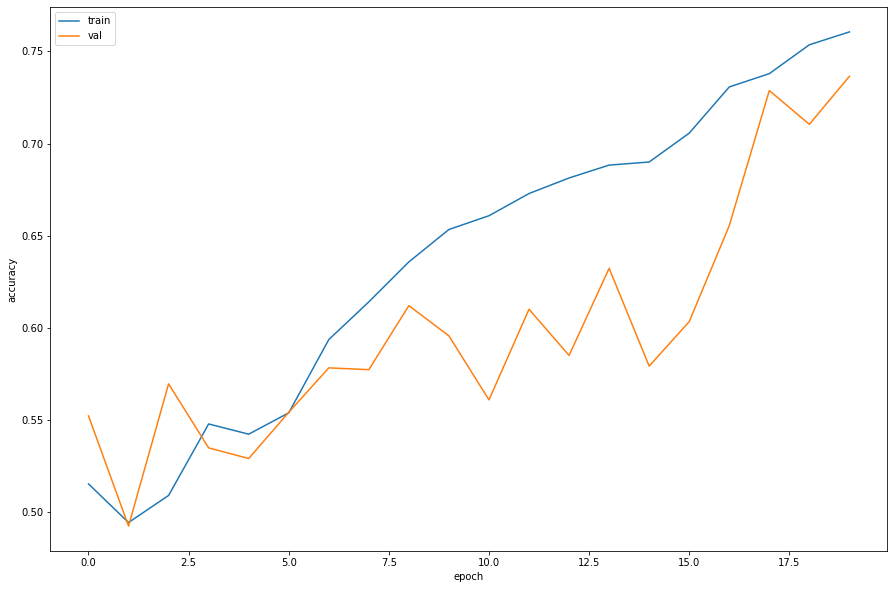

In [36]:
# validation fit model
plt.figure(figsize = (15,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('C:/Users/Felip/Documents/history.png', format='png')
plt.show()

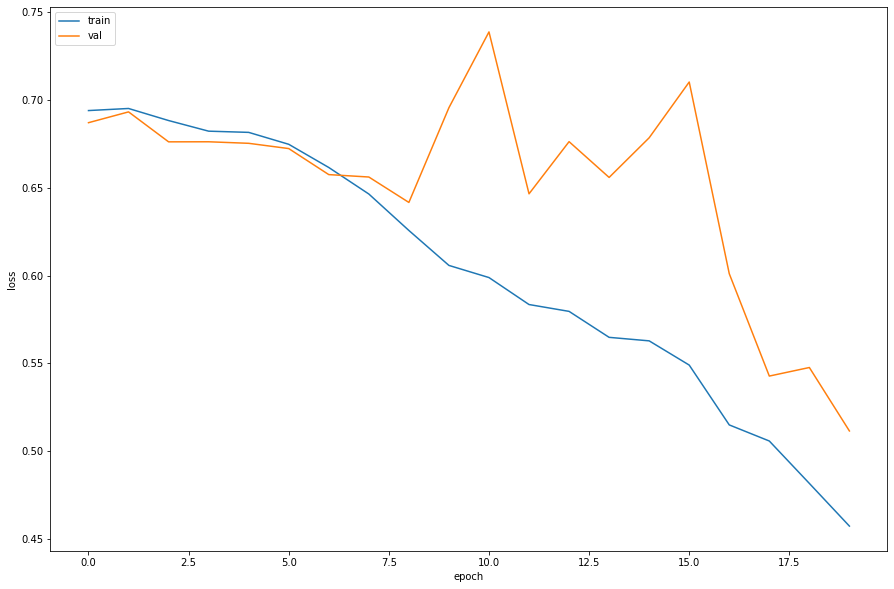

In [37]:
# validation loss model
plt.figure(figsize = (15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('C:/Users/Felip/Documents/loss.png', format='png')
plt.show()

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, accuracy_score

Y_pred = model.predict(val_ds)
y_pred = np.argmax(Y_pred, axis=1)

In [39]:
print(y_pred.shape)

(1036,)


In [45]:
Y_pred

array([[0.6884949 , 0.31150517],
       [0.22364192, 0.77635807],
       [0.7896677 , 0.21033229],
       ...,
       [0.46121734, 0.53878266],
       [0.1289263 , 0.8710737 ],
       [0.845856  , 0.15414402]], dtype=float32)